In [1]:
import pandas as pd
import numpy as np

In [2]:
df_raw = pd.read_csv("../data/aita_comments_Aug17_labels.csv")

In [21]:
df = df_raw[~df_raw['flair_text_y'].isna()]\
    .reset_index(drop=True)\
    .drop('flair_text_x', axis=1)\
    .rename({'flair_text_y': 'flair_text'}, axis=1)
df = df[df['comment_author'] != 'Judgement_Bot_AITA'].reset_index(drop=True)
df = df.rename({
    'score_x': 'comment_score',
    'score_y': 'submission_score'},
    axis=1)
df = df[df['comment'] != '[removed]']
df = df[df['comment'] != '[deleted']
df = df[~df['comment_label'].isna()]

<AxesSubplot:>

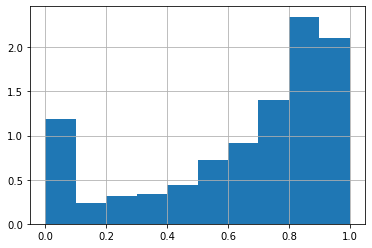

In [4]:
df.groupby('id')['comment_label'].agg(lambda x: (x == 'NTA').mean()).hist(density=True)

In [22]:
nta_prop = df.groupby('id')['comment_label'].agg(lambda x: (x == 'NTA').mean())
nta_prop_middle = nta_prop[(nta_prop > 0) & (nta_prop < 1)]
nta_0 = nta_prop[nta_prop == 0]
nta_1 = nta_prop[nta_prop == 1]

In [23]:
bins = pd.qcut(
    nta_prop_middle,
    q=10,
    labels=[f'decile_{i}' for i in range(10)])\
    .cat\
    .add_categories(['nta_zero', 'nta_one'])\
    .cat\
    .reorder_categories(['nta_zero']
                        + [f'decile_{ii}' for ii in range(10)]
                        + ['nta_one'])

In [24]:
df_binned = df.merge(right=bins.rename('bin'), how='left', on='id')
df_binned.loc[df_binned['id'].isin(nta_0.index), 'bin'] = 'nta_zero'
df_binned.loc[df_binned['id'].isin(nta_1.index), 'bin'] = 'nta_one'

In [25]:
posts_to_get = []
comments = pd.DataFrame()

for cat in bins.cat.categories:
    sample = df_binned[df_binned['bin'] == cat]
    post_idxs = sample.drop_duplicates('id').sort_values('submission_score', ascending=False)['id'].iloc[:10].values
    posts_to_get.append(post_idxs)
    
    comments_sub = sample[sample['id'].isin(post_idxs)].sort_values('comment_score', ascending=False).copy()
    comments = pd.concat((comments, comments_sub))

posts_to_get = np.concatenate(posts_to_get)
comments = comments.reset_index(drop=True)

In [48]:
ruff = comments[comments['id'] == posts_to_get[50]]

In [49]:
top = ruff['comment_label'].iloc[0]

In [52]:
ruff[:1]

,id,comment,comment_score,comment_author,comment_time,comment_parent_id,comment_depth,comment_permalink,author_comment_karma,author_link_karma,...,care_sent,fairness_sent,loyalty_sent,authority_sent,sanctity_sent,moral_nonmoral_ratio,f_var,sent_var,comment_label,bin
2246,z85fyo,"NTA \nWhat kind of person prioritizes, let al...",35478,Risheil,2022-11-29 20:46:44,t3_z85fyo,0,https://reddit.com/r/AmItheAsshole/comments/z8...,46400.0,859.0,...,-0.072188,-0.025548,0.030049,0.001944,-0.067598,2.171429,0.000117,0.001946,NTA,decile_4


In [53]:
alternates = []
final_df = pd.DataFrame()

for post in posts_to_get:
    sub_df = comments[comments['id'] == post].sort_values('comment_score', ascending=False)
    base_label = sub_df.iloc[0]['comment_label']
    disagrees = sub_df[sub_df['comment_label'] != base_label]
    if disagrees.size == 0:
        alternates.append(sub_df.iloc[1]['comment'])
    else:
        alternates.append(disagrees.iloc[0]['comment'])

    final_df = pd.concat((final_df, sub_df[:1]))

In [55]:
final_df['alternate_comment'] = alternates

In [72]:
print(final_df.iloc[61]['selftext'])

To get this out of the way: I'm a flatchested girl. I suffered from health issues and growth problems so I'm small but I'm proud of myself.


My fiance and I went over to his parents house for his niece's birthday. I wore a sweetheart shape dress and my sil (Mel) who always comments on my chest, saw the dress and went like "this dress needs boobs, you ain't got any". I ignored her but then at dinner she asked if I was planning on getting a plastic surgery before the wedding so that I don't "ruin" the wedding dress. I found this offensive especially when others were watching. I said nothing but when we were sitting in the living room later, Mel suddenly started wiping her nose and trying to clear it (it's stuffed due to cold apparently). She has a large nose so I smiled and asked "do you need help with that? I could get the plunger for you.". She was stunned and the room got awkward after her husband was laughing. She was fuming and told my fiance that I stepped out of line and ruined h

In [74]:
print(final_df.iloc[61]['top_comment'])

I’m sorry what? Her comments about your flat chest are out of “concern”? That is an impossibly stupid defense. You are NTA, and also hilarious.


In [75]:
print(final_df.iloc[61]['alternate_comment'])

A bit of an ESH, you WERE actively escalating.  


But tell me: his sister bullies you. In front of your fiancee. And his family. NO ONE DOES A THING.   
And then you're told it was "out of concern".  
Are you ABSOLUTELY SURE you want to marry into this family?


In [81]:
final_df.iloc[61]['gpt_label']

'ESH'

In [79]:
final_df.iloc[61]['gpt_reason']

"Both the OP and the sister-in-law made hurtful comments towards each other. While the sister-in-law's comments were clearly offensive and inappropriate, the OP's retaliatory comment was also mean-spirited. Both parties should take responsibility for their hurtful words and apologize to each other."

In [82]:
final_df.columns

Index(['id', 'comment', 'comment_score', 'comment_author', 'comment_time',
       'comment_parent_id', 'comment_depth', 'comment_permalink',
       'author_comment_karma', 'author_link_karma', 'submission_id', 'title',
       'selftext', 'created_utc', 'permalink', 'submission_score',
       'flair_text', 'top_comment', 'true_label', 'gpt_dilemma', 'gpt_label',
       'gpt_reason', 'care_p', 'fairness_p', 'loyalty_p', 'authority_p',
       'sanctity_p', 'care_sent', 'fairness_sent', 'loyalty_sent',
       'authority_sent', 'sanctity_sent', 'moral_nonmoral_ratio', 'f_var',
       'sent_var', 'comment_label', 'bin', 'alternate_comment'],
      dtype='object')

In [83]:
final_df.to_csv('reference_set_full.csv', index=False)

In [85]:
final_df[[
    'title',
    'selftext',
    'bin',
    'true_label',
    'top_comment',
    'alternate_comment',
    'gpt_label',
    'gpt_reason']].to_csv('reference_set.csv', index=False)